# Shopify Fall 2022 Data Science Intern Challenge

*Alan Milligan - UBC BSc Combined Honours Computer Science and Mathematics*

##  Question 1

### Findings

#### a)
Average Order Value (AOV) as described by the [Shopify blog](https://www.shopify.ca/blog/average-order-value) can be written as follows

$$
\frac{1}{n}\sum_{i=1}^N(\text{value of order } i) = \frac{1}{n}\sum_{i=1}^N\left(\sum_{j=1}^{k_i}(\text{unit cost } j)\cdot(\text{quantity } j)\right)
$$

Taking a look at this, I see two major ways in which is calculation might become misleading. If any order happens have many items (having $k_i$ or quantity $j$ very large in the math) then it can  influence the average significantly or if any order contains a very expensive item (having unit cost $j$ very large) then it too could throw off the AOV. A combination of these issues would make things even worse. Both of these issues stem from the fact that the mean is very sensitive to outliers (the same issue that makes least squares regression fail with outliers).

In this dataset, both of the previously mentioned issues occur, leading to the AOV being very misleading for the average sneaker shop. I will spotlight two shops who appear to be responsible for these issues.

**Shop 42**

Throughout March of 2017, the shop with ID 42 submits 17 orders having order amount \\$704000 and total items 2000. This would likley be some sort of bulk order of similar items, each having an average value of \\$352. While this average could suffer the same  ambiguity described above, it is likley that we are in the first failure case, where the sheer volume of an order is influencing the AOV. In fact, this shop has several orders for 1 item with the order amount being \\$352 (and other small orders with the same average), supporting the hypothesis they made  a bulk order of one medium cost shoe.

**Shop 78**

On the other side of spectrum, all of 78's orders are below 6 items (the majority being 1 or 2 items) each order having average unit cost \\$25725. This very likley means we have a shop selling only the fanciest of fancy shoes and so their order amounts are significantly throwing off the AOV via the second described failure case.

We can look at the summary statistics of order amount with all shops and excluding the above two shops here.


|Summary Statistic   |    All Data| Excluding Shop 42 and 78 |
|  :-- | --- |  --- |
|Count               | 5000| 4903.00     | 
|AOV                 |   3145.13| 300.16 |
|Standard Deviation  |  41282.54| 155.94 |  
|Minimum             |    90.00| 90.00   |
|25% Quartile        |    163.00| 163.00 |  
|50% Quartile        |    284.00| 284.00 | 
|75% Quartile        |    490.00| 386.50 |  
|Maximum             | 704000.00| 1086.00|

While we can see the AOV is now roughly \\$300, which seems much more realistic for sneaker orders, another statistic to note is the standard deviation (which is the expected difference from the AOV) is has dropped from over \\$40000 to about \\$155. This suggest that the new AOV is closer to much more of the remaining  data. These ideas will  inform the next two answers, and were further examined in the analysis section.

#### b)
The main problem we found with AOV was that it is sensitive to outliers, and in this there are outliers that  are inflating it. In situations where this is the case we often use a metric called the *trimmed mean*. Classically we would remove some upper and lower quantile when dealing with values coming from a symmetric distribiton. Since we are dealing with  costs that are stricly positive, and the lower quartile is already relativly close to zero,  we can  use a one sided trimmed mean and remove some upper quantile of the data to create *trimmed Average Order Value*. This is of course under the asumption I can only report one metric. As mentioned in the blog above, a single statistic, no matter what it is, can always be problematic. I would prefer to report several summary statistics such as the table above, but if we need to boil it down to one metric then we can try and make a form of AOV that is as reprentative as possible.

By examining the summary statistics above, specifically the quartile ranges, we can assume that the outliers we are dealing are very few but very large, so trimming a small amount should allow us to effectivly capture the majority  of the "normal" orders. This would be ideal from a business perspective as whatever analysis that applies to these normal orders is likley not useful for shops 42 and 78, who appear to be operating a different sort of business than the other shops. We will chose to keep the bottom 95\% of the data sorted by order amount.

#### c)

The 0.95\%-trimmed AOV is \\$284.7. Interestingly, this (up to rounding) is the same as the median order value of full dataset, which I consider a good sign that this is a reasonable estimate of what the average sneaker order would look like. We also see that the range of the data is now \\$550, as opposed to over \\$700000 previously, which seems more reasonable in this context. With this adjusted metric we have a better idea of how much a customer spends on a given order. Below are the other statistics I would report if I could use more than one metric.

|Summary Statistic   |   95\%-trimmed Data|
|  :-- | --- |
|Count               | 4750|
|AOV                 |   284.70|
|Standard Deviation  |  133.08|
|Minimum             |    90.00|
|25\% Quartile        |    161.00|
|50\% Quartile        |    272.00|
|75\% Quartile        |    362.00|
|Maximum             | 640.00|



### Analysis

My first step with any data analysis or machine learning task is to simply take a look at the data. I can see what sort of data we are dealing with, if there are any immediate red flags, and decide what to look at  next.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

dataset_name = "2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv"
data = pd.read_csv(dataset_name)
data.head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11
5,6,58,882,138,1,credit_card,2017-03-14 15:25:01
6,7,87,915,149,1,cash,2017-03-01 21:37:57
7,8,22,761,292,2,cash,2017-03-08 2:05:38
8,9,64,914,266,2,debit,2017-03-17 20:56:50
9,10,52,788,146,1,credit_card,2017-03-30 21:08:26


In [115]:
data[["order_amount","total_items"]].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


So it lookslike we have some fairly standard data about orders, but luckily I happened to look at enough to notice one strange entry on line 15. It is clearly an outlier in both the order amount and total items column, which may be a clue to why the origional AOV is so high. Glancing at the summary statistics for our numerical values, we see the origional AOV reported (\\$3145.13), and below it a standard deviation over \\$40000. This is a big red flag to me as that suggests there are orders that are much much larger than the reported AOV, espcially since this is a dollar amount bounded below by 0. The total items standard deviation also seems a bit high, but not quite as extreme. To further examine this hypothesis we can do some visualization.

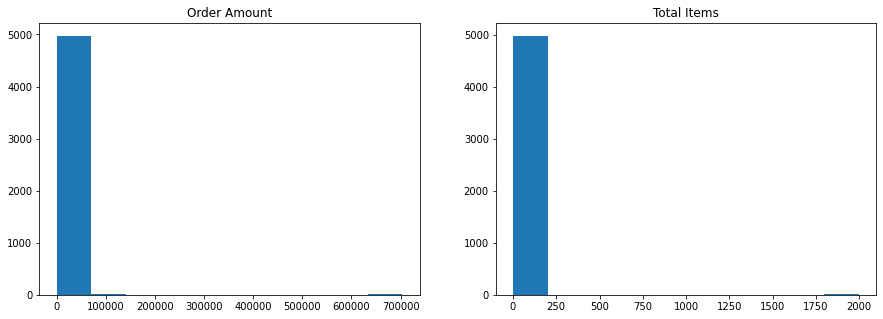

In [97]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(data.order_amount)
plt.title("Order Amount")
plt.subplot(1,2,2)
plt.title("Total Items")
plt.hist(data.total_items)
plt.show()

So we can see there are some outliers in the data, but the differences in scale make it hard to see what's going on. We can try and see a bit more by using logarithmic scale and using some more bins.

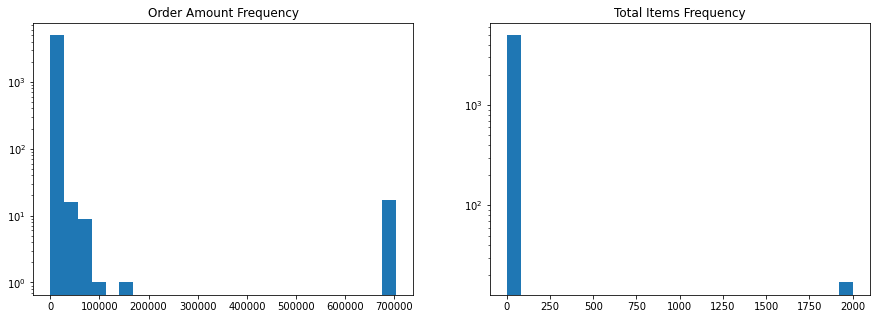

In [117]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(data.order_amount, log=True, bins=25)
plt.title("Order Amount Frequency")
plt.subplot(1,2,2)
plt.title("Total Items Frequency")
plt.hist(data.total_items, log=True, bins=25)
plt.show()

So here we can see whats going on a little better. There is very clearly some outliers in order amount at round \\$700000, and likewise in total items around 2000. We can also see there is somewhat of an outlier in order amount near \\$150000, which is again quite a bit for a shoe order. From here I want to see if there is anything interesting about these outlier datapoints, which we can do by looking at the sorted data. By looking at the histogram, I can see there is around 15 datapoints with the around \\$700000 value, so I will try and look a bit past that.

In [107]:
data.sort_values(by=["order_amount"], ascending=False).head(30)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
2835,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
4882,4883,42,607,704000,2000,credit_card,2017-03-25 4:00:00


Great, so we can see all of the \\$700000 order amount outliers, and notice that they are also (at least part of) the outliers in order amount. They are also coming from the same shop, so it seems this is some sort of bulk order as opposed to just selling to average consumers. When we looked at the data earlier it appeared that most of the orders were small and likley headed to customers, so it may make sense to exclude shop 78 if it is a different type of shoe business. This got me thinking about AOV per store, rather than across all stores. We can calculate that and take a look as follows.

In [108]:
data.groupby(["shop_id"])["order_amount"].mean().sort_values()

shop_id
92        162.857143
2         174.327273
32        189.976190
100       213.675000
53        214.117647
           ...      
38        390.857143
90        403.224490
50        403.545455
78      49213.043478
42     235101.490196
Name: order_amount, Length: 100, dtype: float64

Now things are starting to make sense. We have two shops (78 and 42) with huge AOV, where all the other shops are between \\$405 and \\$160, which seem like reasonable average order values for a sneaker shop. This makes me wonder what the data would look like if we excluded these two shops, which we can do.

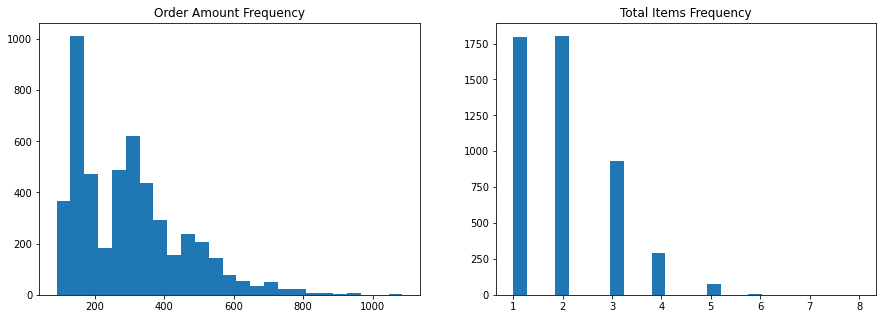

In [119]:
filtered_data =  data[(data.shop_id != 78) &  (data.shop_id != 42)]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(filtered_data.order_amount, log=False, bins=25)
plt.title("Order Amount Frequency")
plt.subplot(1,2,2)
plt.title("Total Items Frequency")
plt.hist(filtered_data.total_items, log=False, bins=25)
plt.show()

Now this looks a bit more normal, roughly following the rank-frequency inverse relationship often seen in data. That being said, I don't feel like the best rule is just kick out two shops after looking at the data. If we wanted to expand this dataset we might quickly run into the same issue if another outlier shop shows up. Instead, we can take a slightly more principled approach and use something like the trimmed mean, often used in situations where we would like an average of sorts but don't want to a victim of outliers. Often this is done by something like an interquartile mean where we only take the mean in the interquartile range, but looking at this data I think only trimming the upper end is appropriate. This is because we know that both order amount and total items are bounded below by zero, so we don't have to worry about running into a massive negative value. I will take the values below the 95\% quantile given that it seems nearly all of our data is "normal" orders rather than outliers.

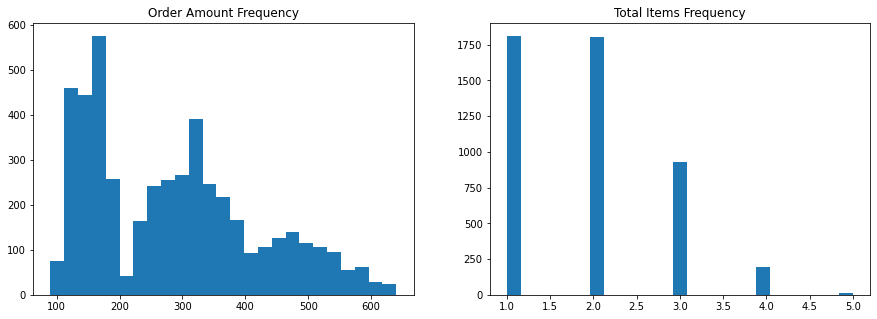

In [122]:
total_records = data.count()[0]
kept_records = int(0.95*total_records)
trimmed_data = data.sort_values(["order_amount"])[0:kept_records]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(trimmed_data.order_amount, log=False, bins=25)
plt.title("Order Amount Frequency")
plt.subplot(1,2,2)
plt.title("Total Items Frequency")
plt.hist(trimmed_data.total_items, log=False, bins=25)
plt.show()

This looks more like something we can make business decisions with, and we can see from the summary statistics below the standard deviation is now a level that makes sense in this context (I don't know much about shoes but \$133 seems like it could be difference between 2 pairs and 3 pairs).

In [124]:
trimmed_data[["order_amount","total_items"]].describe()

,order_amount,total_items
count,4750.000000,4750.000000
mean,284.705684,1.903789
std,133.079491,0.868124
min,90.000000,1.000000
25%,161.000000,1.000000
50%,272.000000,2.000000
75%,362.000000,2.000000
max,640.000000,5.000000


## Question 2

For the following queries I am going to use "manual" joins on tables' primary keys rather than SQL's built in JOIN keyword and its variants as in the case of the following queries it is a bit more succinct. The result of each query is displayed as a table following the query.

#### a)


```SQL
SELECT COUNT(O.OrderID) AS SpeedyExpressOrders
FROM Orders O, Shippers S
WHERE O.ShipperID = S.ShipperID
AND S.ShipperName = "Speedy Express";
```

<table class="ws-table-all notranslate"><tbody><tr><th>SpeedyExpressOrders</th></tr><tr><td>54</td></tr></tbody></table>

Here we join the Orders table and Shippers table by ShipperID so that each record (corresponding to an order) will have its shipper information attached. Then, we keep only the records that have ShipperName "Speedy Express." Finally, we count the number of orders remaining by their unique primary key OrderID to reach the final answer.

#### b)

```SQL
SELECT E.LastName, COUNT(O.OrderID) AS OrderCount 
FROM Employees E, Orders O
WHERE E.EmployeeID = O.EmployeeID
GROUP BY E.EmployeeID 
ORDER BY OrderCount DESC
LIMIT 1;
```


<table class="ws-table-all notranslate"><tbody><tr><th>LastName</th><th>OrderCount</th></tr><tr><td>Peacock</td><td>40</td></tr></tbody></table>

Similar with the previous query, we manually join the Employees and Orders tables on Employee ID so that each order will have the name of the employee handling it attached. From this, we group on each employee and aggregate the number of orders handled by this employee into the new column OrderCount. We then order the remaining records by OrderCount from largest to smallest, and keep the top record as our result.

#### c)

```SQL
SELECT P.ProductName, SUM(OD.Quantity) AS ProductsOrdered 
FROM Orders O, OrderDetails OD, Customers C, Products P
WHERE C.CustomerID = O.CustomerID
AND O.OrderID = OD.OrderID
AND OD.ProductID = P.ProductID
AND C.Country = "Germany"
GROUP BY P.ProductID
ORDER BY SUM(OD.Quantity) DESC
LIMIT 1;
```

<table class="ws-table-all notranslate"><tbody><tr><th>ProductName</th><th>ProductsOrdered</th></tr><tr><td>Boston Crab Meat</td><td>160</td></tr></tbody></table>

*Assumption: "ordered the most by customers in Germany" means of all products, this product had the most **units** sent to Germany, **not** the most **orders** originating from Germany*

We start by doing a very large join between Orders, OrderDetails, Customers, and Products in order to connect Country (in the Customers table) to ProductID (in the Products table) and get access to Quantity (in the OrderDetails table) along the way. Then, we filter to only have records of orders from customers in Germany as desired, and we group by ProductID aggregating by adding up all the units sold for each product into a new column called ProductsOrdered. We then sort by the ProductsOrdered column and take the ProductName and  ProductsOrdered from the top entry as our answer.